In [1]:
# NLTK Sentiment Analysis - Doar Engleză (Fără Custom Words)
# Notebook simplificat pentru analiza sentiment doar cu VADER + TextBlob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import pentru sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import re
import glob
import os
from datetime import datetime

# Setup
plt.style.use('default')
sns.set_palette("husl")

print("=== NLTK SENTIMENT ANALYSIS (DOAR ENGLEZĂ) ===")

=== NLTK SENTIMENT ANALYSIS (DOAR ENGLEZĂ) ===


In [2]:
# 1. SETUP SENTIMENT ANALYZERS

print("Descarcă resurse NLTK...")
nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)

print("Inițializează VADER...")
vader = SentimentIntensityAnalyzer()

print("Setup complet - doar VADER + TextBlob!")

Descarcă resurse NLTK...
Inițializează VADER...
Setup complet - doar VADER + TextBlob!


In [3]:
# 2. LOAD DATA

# Găsește cel mai recent CSV
csv_files = glob.glob('data/reddit_data_*.csv')
if not csv_files:
    print("EROARE: Nu s-au găsit fișiere CSV în directorul 'data/'")
    print("Rulează reddit_scraper_final.py pentru a genera date")
    exit()

latest_csv = max(csv_files, key=lambda f: os.path.getctime(f))
print(f"Încarcă: {latest_csv}")

df = pd.read_csv(latest_csv)
print(f"Date încărcate: {len(df)} rânduri")
print(f"Coloane: {list(df.columns)}")

Încarcă: data/reddit_data_20250920_121210.csv
Date încărcate: 3880 rânduri
Coloane: ['id', 'type', 'keyword', 'subreddit', 'author', 'title', 'text', 'score', 'num_comments', 'created_utc', 'url', 'scraped_at']



=== EXPLORAREA DATELOR ===
Total posts/comments: 3880
Keywords unice: 10
Score mediu Reddit: 189.64
Comentarii medii: 29.78


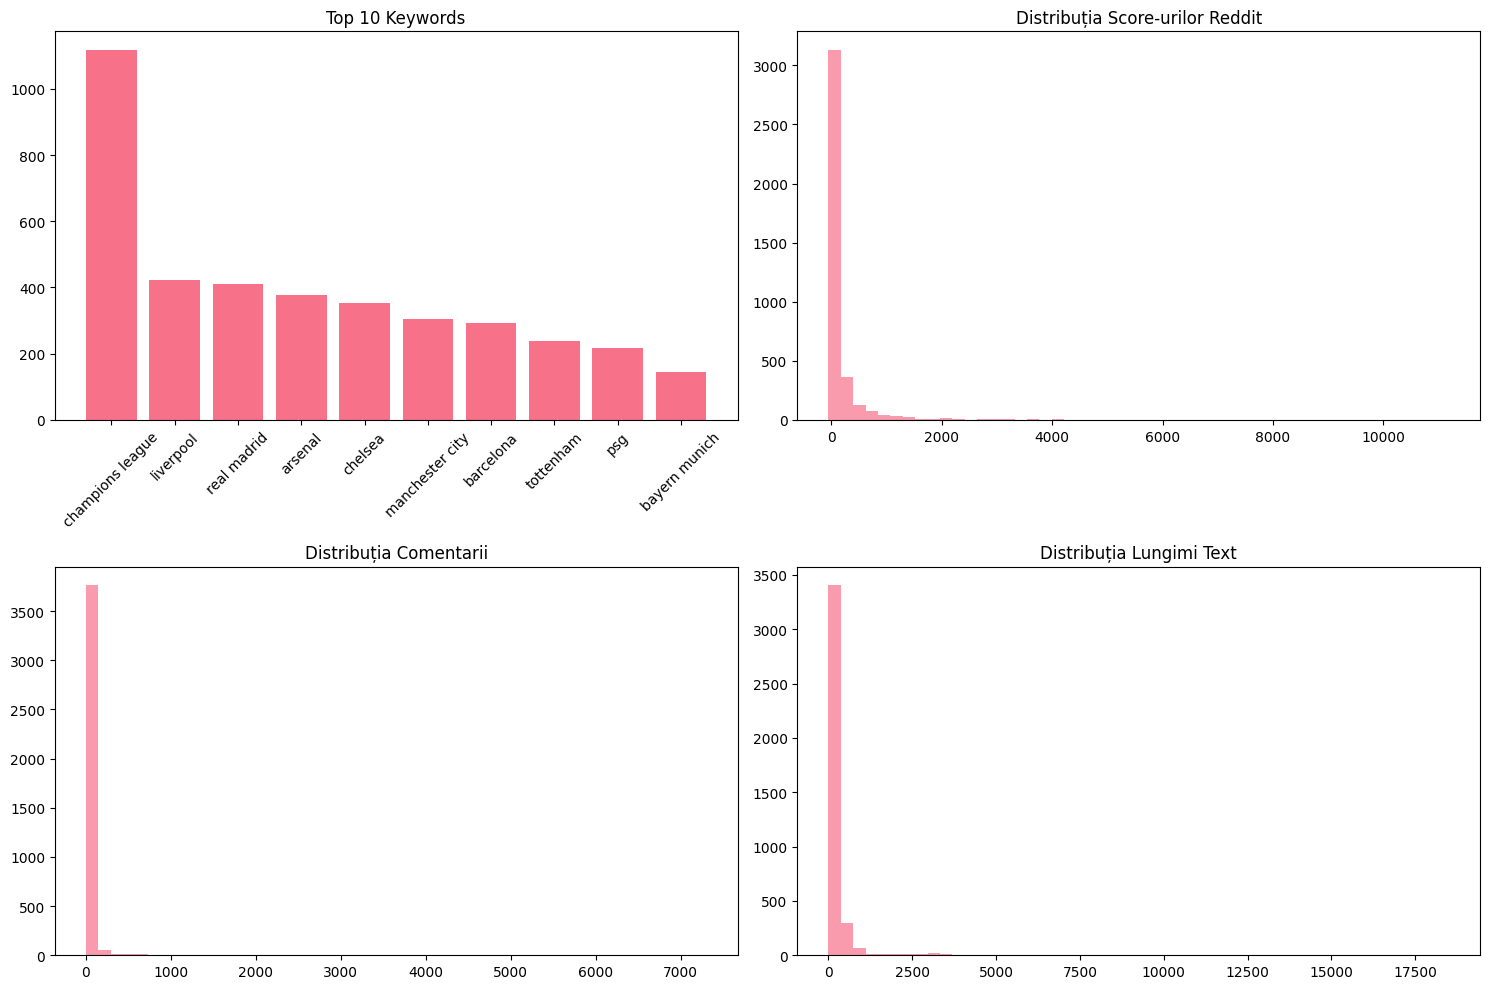

In [4]:
# 3. DATA EXPLORATION

print("\n=== EXPLORAREA DATELOR ===")
print(f"Total posts/comments: {len(df)}")
if 'keyword' in df.columns:
    print(f"Keywords unice: {df['keyword'].nunique()}")
if 'score' in df.columns:
    print(f"Score mediu Reddit: {df['score'].mean():.2f}")
if 'num_comments' in df.columns:
    print(f"Comentarii medii: {df['num_comments'].mean():.2f}")

# Grafice de bază
if 'keyword' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Keywords distribution
    keyword_counts = df['keyword'].value_counts().head(10)
    axes[0,0].bar(keyword_counts.index, keyword_counts.values)
    axes[0,0].set_title('Top 10 Keywords')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Score distribution
    if 'score' in df.columns:
        axes[0,1].hist(df['score'], bins=50, alpha=0.7)
        axes[0,1].set_title('Distribuția Score-urilor Reddit')
        
    # Comments distribution
    if 'num_comments' in df.columns:
        axes[1,0].hist(df['num_comments'], bins=50, alpha=0.7)
        axes[1,0].set_title('Distribuția Comentarii')
    
    # Text length distribution
    df['text_length'] = df['text'].astype(str).str.len()
    axes[1,1].hist(df['text_length'], bins=50, alpha=0.7)
    axes[1,1].set_title('Distribuția Lungimi Text')
    
    plt.tight_layout()
    plt.show()

In [6]:
# 4. SENTIMENT ANALYSIS FUNCTIONS (SIMPLIFICAT)

def clean_text(text):
    """Curăță textul pentru analiză"""
    if pd.isna(text) or not text:
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http[s]?://\S+', '', text)  # URLs
    text = re.sub(r'u/\w+', '', text)  # mentions
    text = re.sub(r'r/\w+', '', text)  # subreddits
    text = re.sub(r'[^\w\s!?.,;:\'"()-]', ' ', text)  # special chars
    text = re.sub(r'\s+', ' ', text)  # multiple spaces
    return text.strip()

def analyze_text_sentiment(text, title=""):
    """Analizează sentiment doar cu VADER + TextBlob (fără custom words)"""
    full_text = f"{title} {text}".strip()
    clean_text_result = clean_text(full_text)
    
    if not clean_text_result or len(clean_text_result) < 3:
        return {
            'vader_compound': 0, 'vader_pos': 0, 'vader_neg': 0, 'vader_neu': 1,
            'textblob_polarity': 0, 'textblob_subjectivity': 0,
            'final_score': 0, 'sentiment_label': 'neutral',
            'confidence': 0, 'text_length': 0
        }
    
    # VADER analysis
    vader_scores = vader.polarity_scores(clean_text_result)
    
    # TextBlob analysis
    blob = TextBlob(clean_text_result)
    textblob_polarity = blob.sentiment.polarity
    textblob_subjectivity = blob.sentiment.subjectivity
    
    # Final score: VADER 60%, TextBlob 40% (fără custom)
    final_score = (
        vader_scores['compound'] * 0.6 +
        textblob_polarity * 0.4
    )
    
    # Label classification
    if final_score > 0.1:
        label = 'positive'
        confidence = min(abs(final_score), 1.0)
    elif final_score < -0.1:
        label = 'negative'
        confidence = min(abs(final_score), 1.0)
    else:
        label = 'neutral'
        confidence = 1.0 - abs(final_score)
    
    return {
        'vader_compound': round(vader_scores['compound'], 3),
        'vader_pos': round(vader_scores['pos'], 3),
        'vader_neg': round(vader_scores['neg'], 3),
        'vader_neu': round(vader_scores['neu'], 3),
        'textblob_polarity': round(textblob_polarity, 3),
        'textblob_subjectivity': round(textblob_subjectivity, 3),
        'final_score': round(final_score, 3),
        'sentiment_label': label,
        'confidence': round(confidence, 3),
        'text_length': len(clean_text_result)
    }

print("Funcții sentiment definite (doar VADER + TextBlob)!")

Funcții sentiment definite (doar VADER + TextBlob)!


In [7]:
# 5. PROCESS ALL DATA

print("\n=== PROCESARE SENTIMENT ===")

results = []
for index, row in df.iterrows():
    text = str(row.get('text', ''))
    title = str(row.get('title', ''))
    
    sentiment_result = analyze_text_sentiment(text, title)
    
    row_result = row.to_dict()
    row_result.update(sentiment_result)
    results.append(row_result)
    
    if (index + 1) % 50 == 0:
        print(f"Procesat: {index + 1}/{len(df)}")

df_analyzed = pd.DataFrame(results)
print(f"Analiză completă! {len(df_analyzed)} items procesate")


=== PROCESARE SENTIMENT ===
Procesat: 50/3880
Procesat: 100/3880
Procesat: 150/3880
Procesat: 200/3880
Procesat: 250/3880
Procesat: 300/3880
Procesat: 350/3880
Procesat: 400/3880
Procesat: 450/3880
Procesat: 500/3880
Procesat: 550/3880
Procesat: 600/3880
Procesat: 650/3880
Procesat: 700/3880
Procesat: 750/3880
Procesat: 800/3880
Procesat: 850/3880
Procesat: 900/3880
Procesat: 950/3880
Procesat: 1000/3880
Procesat: 1050/3880
Procesat: 1100/3880
Procesat: 1150/3880
Procesat: 1200/3880
Procesat: 1250/3880
Procesat: 1300/3880
Procesat: 1350/3880
Procesat: 1400/3880
Procesat: 1450/3880
Procesat: 1500/3880
Procesat: 1550/3880
Procesat: 1600/3880
Procesat: 1650/3880
Procesat: 1700/3880
Procesat: 1750/3880
Procesat: 1800/3880
Procesat: 1850/3880
Procesat: 1900/3880
Procesat: 1950/3880
Procesat: 2000/3880
Procesat: 2050/3880
Procesat: 2100/3880
Procesat: 2150/3880
Procesat: 2200/3880
Procesat: 2250/3880
Procesat: 2300/3880
Procesat: 2350/3880
Procesat: 2400/3880
Procesat: 2450/3880
Procesat: 2


=== DISTRIBUȚIA SENTIMENT ===
Distribuție sentiment (VADER + TextBlob):
  positive: 2030 (52.3%)
  neutral: 1132 (29.2%)
  negative: 718 (18.5%)


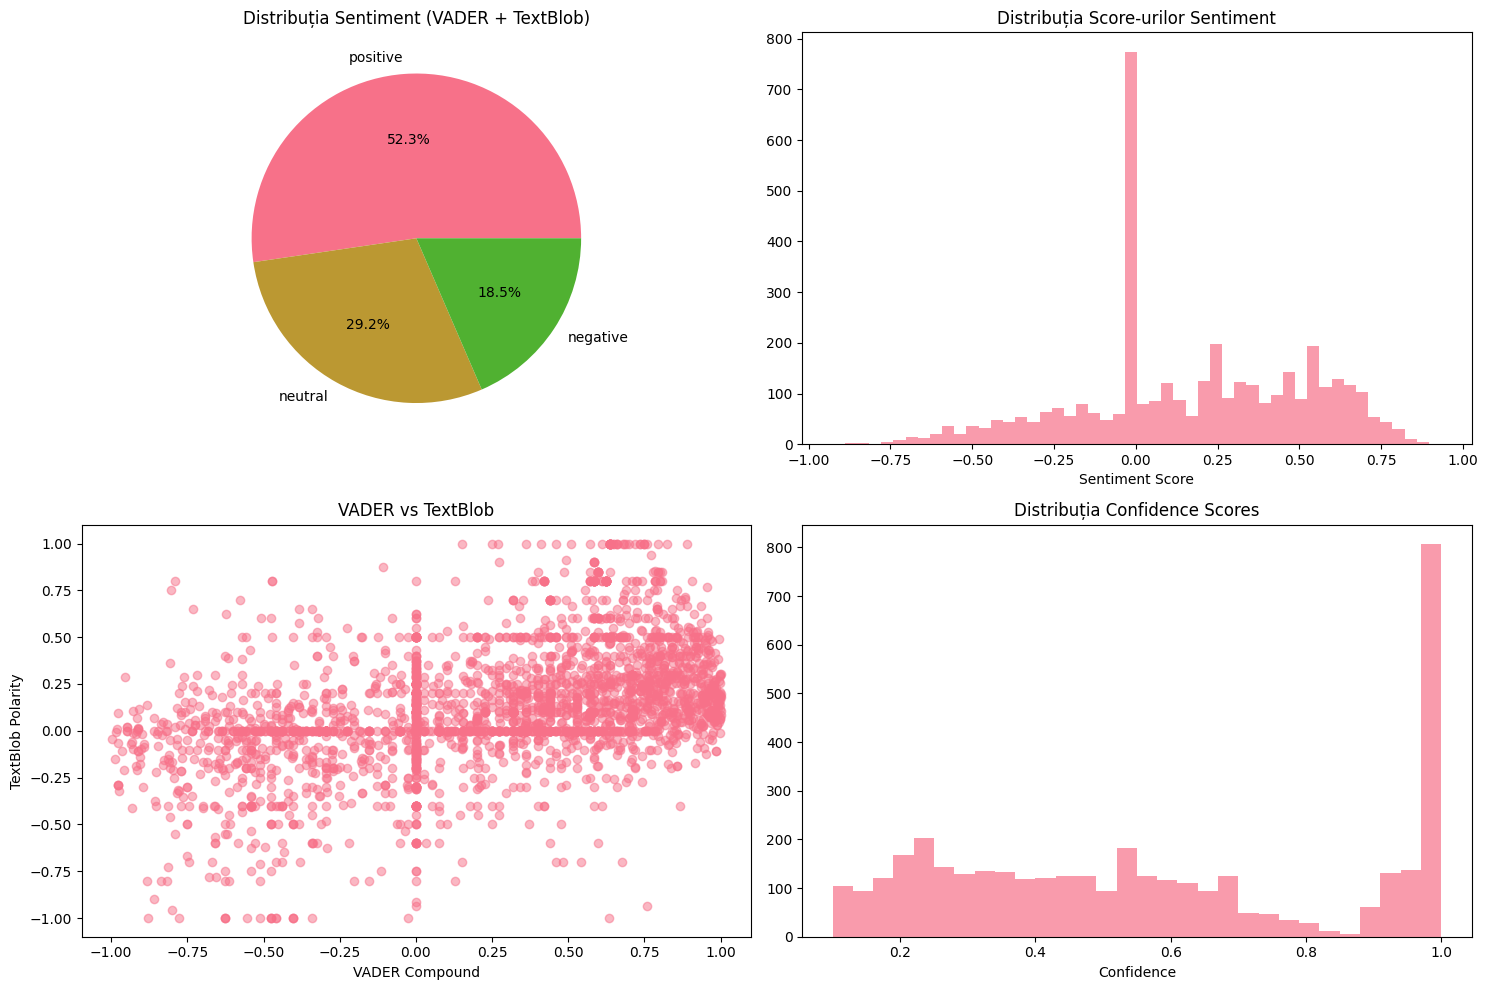

In [8]:
# 6. SENTIMENT DISTRIBUTION

print("\n=== DISTRIBUȚIA SENTIMENT ===")

sentiment_counts = df_analyzed['sentiment_label'].value_counts()
print("Distribuție sentiment (VADER + TextBlob):")
for label, count in sentiment_counts.items():
    percentage = round(count / len(df_analyzed) * 100, 1)
    print(f"  {label}: {count} ({percentage}%)")

# Grafice distribuție sentiment
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Pie chart sentiment distribution
axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Distribuția Sentiment (VADER + TextBlob)')

# Histogram final scores
axes[0,1].hist(df_analyzed['final_score'], bins=50, alpha=0.7)
axes[0,1].set_title('Distribuția Score-urilor Sentiment')
axes[0,1].set_xlabel('Sentiment Score')

# VADER vs TextBlob comparison
axes[1,0].scatter(df_analyzed['vader_compound'], df_analyzed['textblob_polarity'], alpha=0.5)
axes[1,0].set_xlabel('VADER Compound')
axes[1,0].set_ylabel('TextBlob Polarity')
axes[1,0].set_title('VADER vs TextBlob')

# Confidence distribution
axes[1,1].hist(df_analyzed['confidence'], bins=30, alpha=0.7)
axes[1,1].set_title('Distribuția Confidence Scores')
axes[1,1].set_xlabel('Confidence')

plt.tight_layout()
plt.show()


=== SENTIMENT PE KEYWORDS ===
Top 10 keywords cu sentiment pozitiv:
                  final_score sentiment_label  confidence
keyword                                                  
psg                     0.207        positive       0.587
champions league        0.197        positive       0.579
barcelona               0.195        positive       0.596
tottenham               0.178        positive       0.609
manchester city         0.176        positive       0.584
arsenal                 0.175        positive       0.577
liverpool               0.154        positive       0.580
chelsea                 0.142        positive       0.552
bayern munich           0.107        positive       0.593
real madrid             0.107        positive       0.579


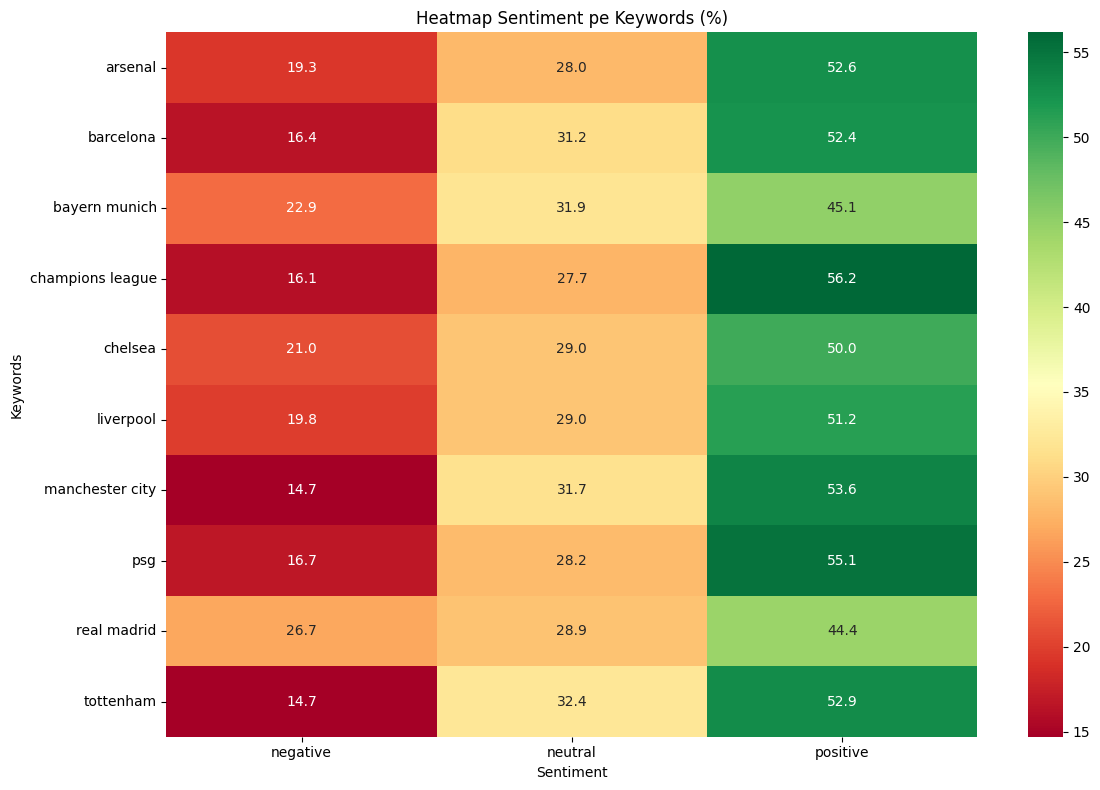

In [9]:
# 7. SENTIMENT BY KEYWORD

if 'keyword' in df_analyzed.columns:
    print("\n=== SENTIMENT PE KEYWORDS ===")
    
    keyword_sentiment = df_analyzed.groupby('keyword').agg({
        'final_score': 'mean',
        'sentiment_label': lambda x: x.value_counts().index[0],
        'confidence': 'mean'
    }).round(3)
    
    keyword_sentiment = keyword_sentiment.sort_values('final_score', ascending=False)
    print("Top 10 keywords cu sentiment pozitiv:")
    print(keyword_sentiment.head(10))
    
    # Heatmap sentiment pe keyword
    sentiment_keyword_pivot = pd.crosstab(df_analyzed['keyword'], df_analyzed['sentiment_label'], normalize='index') * 100
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(sentiment_keyword_pivot, annot=True, fmt='.1f', cmap='RdYlGn')
    plt.title('Heatmap Sentiment pe Keywords (%)')
    plt.ylabel('Keywords')
    plt.xlabel('Sentiment')
    plt.tight_layout()
    plt.show()


=== ANALIZA CORELAȚIEI: SENTIMENT vs ENGAGEMENT ===


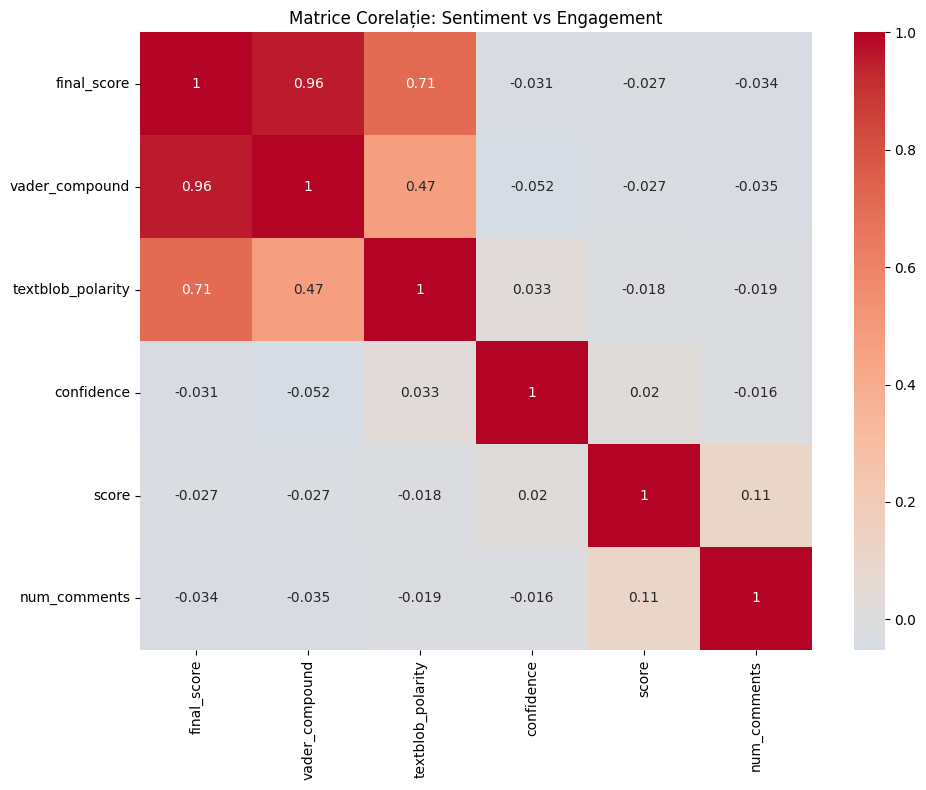

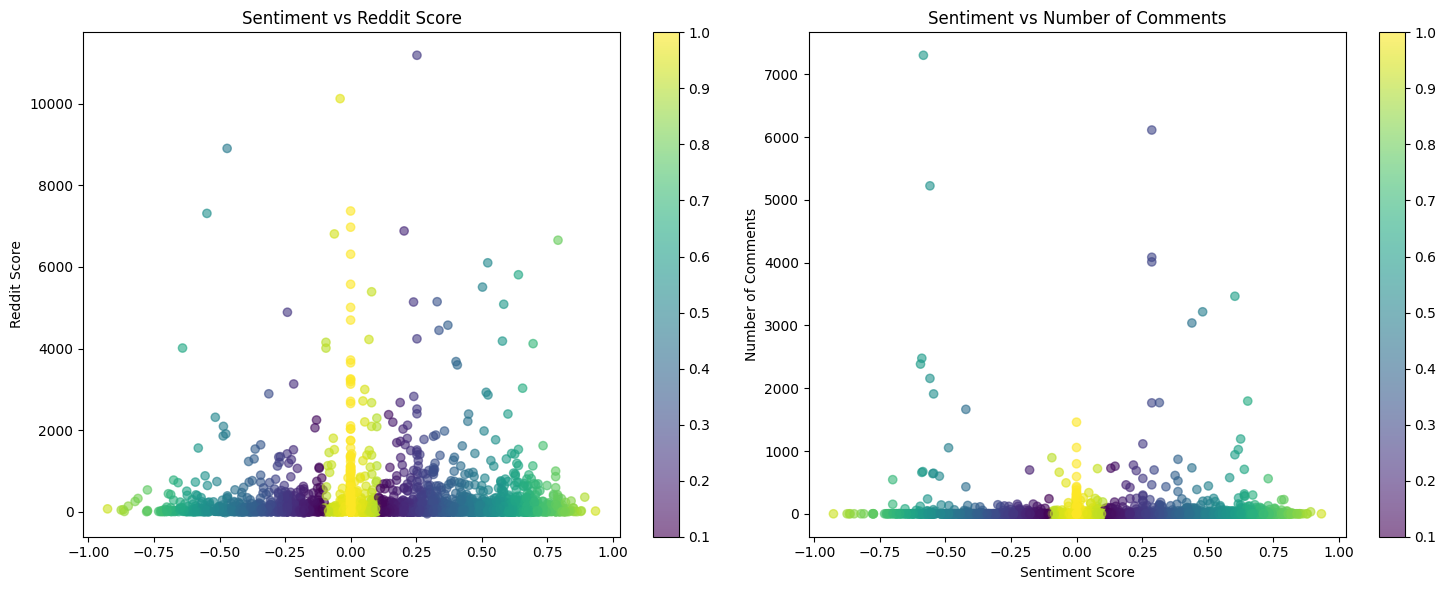


Statistici engagement pe sentiment:
                  score  num_comments
sentiment_label                      
negative         186.61         46.38
neutral          222.49         17.59
positive         172.40         30.70

Corelații sentiment vs engagement:
  Sentiment vs score: -0.027
  Sentiment vs num_comments: -0.034


In [10]:
# 8. CORRELATION ANALYSIS - SENTIMENT vs ENGAGEMENT

print("\n=== ANALIZA CORELAȚIEI: SENTIMENT vs ENGAGEMENT ===")

engagement_cols = []
if 'score' in df_analyzed.columns:
    engagement_cols.append('score')
if 'num_comments' in df_analyzed.columns:
    engagement_cols.append('num_comments')
if 'upvote_ratio' in df_analyzed.columns:
    engagement_cols.append('upvote_ratio')

if engagement_cols:
    # Corelații
    corr_data = df_analyzed[['final_score', 'vader_compound', 'textblob_polarity', 'confidence'] + engagement_cols]
    correlation_matrix = corr_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matrice Corelație: Sentiment vs Engagement')
    plt.tight_layout()
    plt.show()
    
    # Scatter plots pentru corelații
    if 'score' in engagement_cols and 'num_comments' in engagement_cols:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Sentiment vs Reddit Score
        scatter1 = axes[0].scatter(df_analyzed['final_score'], df_analyzed['score'], 
                                  c=df_analyzed['confidence'], cmap='viridis', alpha=0.6)
        axes[0].set_xlabel('Sentiment Score')
        axes[0].set_ylabel('Reddit Score')
        axes[0].set_title('Sentiment vs Reddit Score')
        plt.colorbar(scatter1, ax=axes[0])
        
        # Sentiment vs Comments
        scatter2 = axes[1].scatter(df_analyzed['final_score'], df_analyzed['num_comments'],
                                  c=df_analyzed['confidence'], cmap='viridis', alpha=0.6)
        axes[1].set_xlabel('Sentiment Score')
        axes[1].set_ylabel('Number of Comments')
        axes[1].set_title('Sentiment vs Number of Comments')
        plt.colorbar(scatter2, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
    
    # Statistici pe sentimente
    print("\nStatistici engagement pe sentiment:")
    engagement_by_sentiment = df_analyzed.groupby('sentiment_label')[engagement_cols].mean().round(2)
    print(engagement_by_sentiment)
    
    # Corelații individuale
    print(f"\nCorelații sentiment vs engagement:")
    for col in engagement_cols:
        corr = df_analyzed['final_score'].corr(df_analyzed[col])
        print(f"  Sentiment vs {col}: {corr:.3f}")

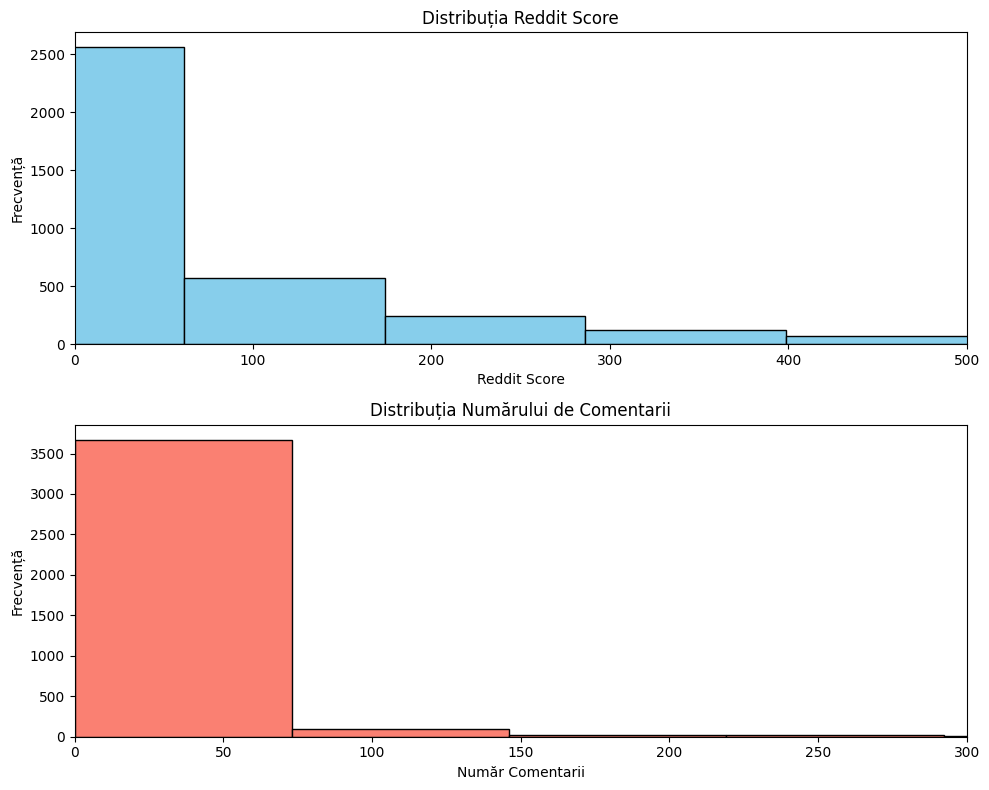

In [15]:
import matplotlib.pyplot as plt

# Creează figura cu 2 axe (2 rânduri, 1 coloană)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Histogramă pentru Reddit Score
axes[0].hist(df['score'], bins=100, color='skyblue', edgecolor='black')
axes[0].set_title('Distribuția Reddit Score')
axes[0].set_xlabel('Reddit Score')
axes[0].set_ylabel('Frecvență')

# Histogramă pentru Numărul de Comentarii
axes[1].hist(df['num_comments'], bins=100, color='salmon', edgecolor='black')
axes[1].set_title('Distribuția Numărului de Comentarii')
axes[1].set_xlabel('Număr Comentarii')
axes[1].set_ylabel('Frecvență')

axes[0].set_xlim(0, 500)
axes[1].set_xlim(0, 300)


# Ajustează spațiile dintre grafice
plt.tight_layout()
plt.show()


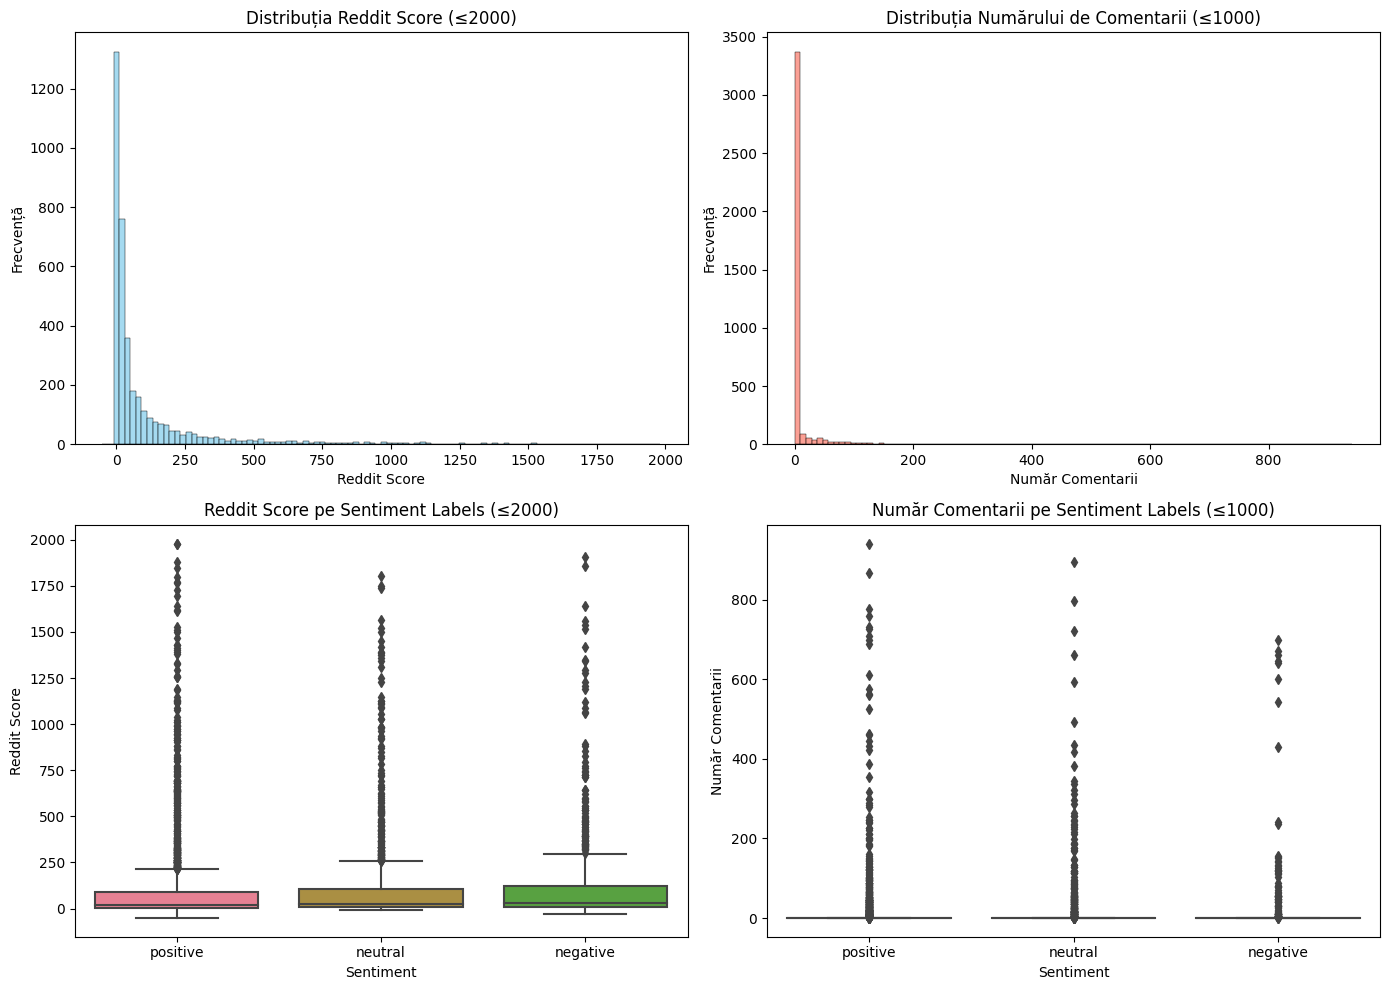

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creează figura cu 2 rânduri și 2 coloane
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogramă pentru Reddit Score (limităm la 2000 ca să nu strice outlierii)
sns.histplot(df_analyzed[df_analyzed['score'] <= 2000]['score'], bins=100, color='skyblue', ax=axes[0,0])
axes[0,0].set_title('Distribuția Reddit Score (≤2000)')
axes[0,0].set_xlabel('Reddit Score')
axes[0,0].set_ylabel('Frecvență')

# Histogramă pentru Numărul de Comentarii (limităm la 1000)
sns.histplot(df_analyzed[df_analyzed['num_comments'] <= 1000]['num_comments'], bins=100, color='salmon', ax=axes[0,1])
axes[0,1].set_title('Distribuția Numărului de Comentarii (≤1000)')
axes[0,1].set_xlabel('Număr Comentarii')
axes[0,1].set_ylabel('Frecvență')

# Boxplot pentru Reddit Score (limităm la 2000)
sns.boxplot(data=df_analyzed[df_analyzed['score'] <= 2000], x='sentiment_label', y='score', ax=axes[1,0])
axes[1,0].set_title('Reddit Score pe Sentiment Labels (≤2000)')
axes[1,0].set_xlabel('Sentiment')
axes[1,0].set_ylabel('Reddit Score')

# Boxplot pentru Numărul de Comentarii (limităm la 1000)
sns.boxplot(data=df_analyzed[df_analyzed['num_comments'] <= 1000], x='sentiment_label', y='num_comments', ax=axes[1,1])
axes[1,1].set_title('Număr Comentarii pe Sentiment Labels (≤1000)')
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('Număr Comentarii')

# Ajustează spațiile dintre grafice
plt.tight_layout()
plt.show()



=== BOXPLOTS ENGAGEMENT ===


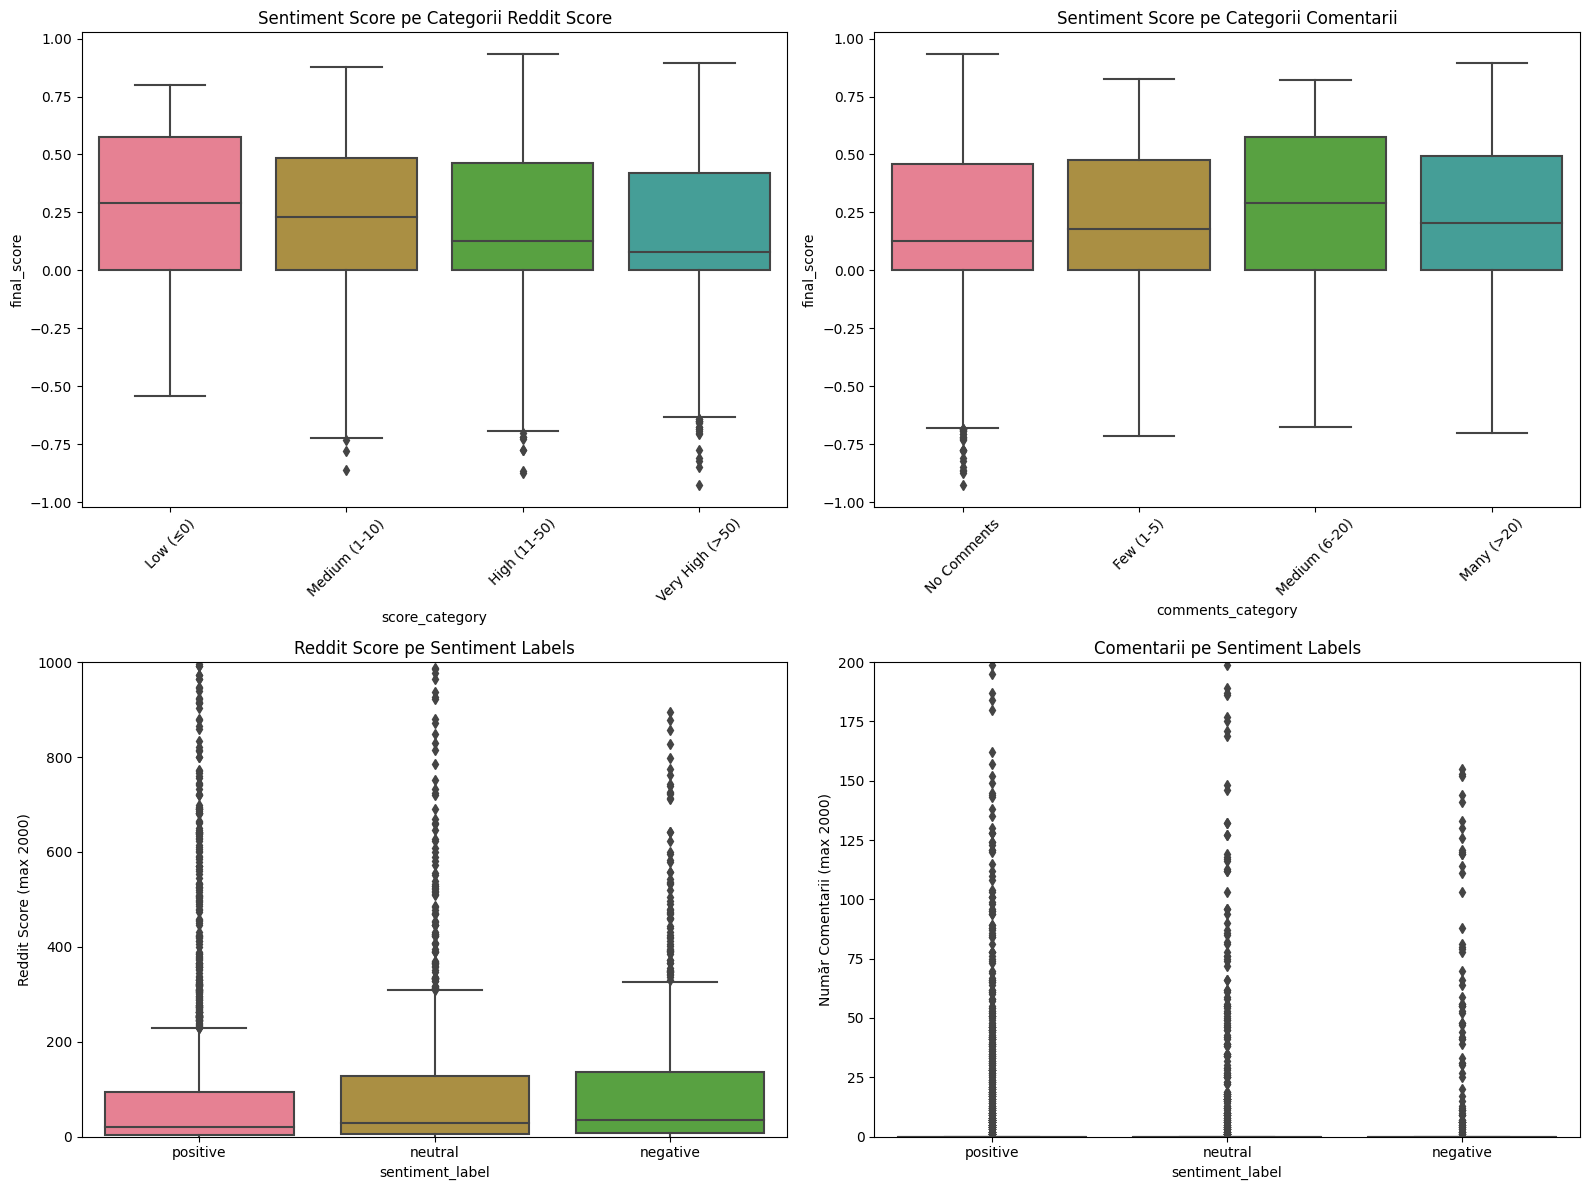

In [26]:
# 9. BOXPLOTS - SENTIMENT vs ENGAGEMENT
print("\n=== BOXPLOTS ENGAGEMENT ===")
if engagement_cols:
    # Creează categorii pentru analiza boxplot
    if 'score' in engagement_cols:
        df_analyzed['score_category'] = pd.cut(df_analyzed['score'], 
                                             bins=[-np.inf, 0, 10, 50, np.inf], 
                                             labels=['Low (≤0)', 'Medium (1-10)', 'High (11-50)', 'Very High (>50)'])
    
    if 'num_comments' in engagement_cols:
        df_analyzed['comments_category'] = pd.cut(df_analyzed['num_comments'], 
                                                bins=[-np.inf, 0, 5, 20, np.inf], 
                                                labels=['No Comments', 'Few (1-5)', 'Medium (6-20)', 'Many (>20)'])
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Boxplot: Reddit Score categories vs Sentiment
    if 'score' in engagement_cols:
        sns.boxplot(data=df_analyzed, x='score_category', y='final_score', ax=axes[0,0])
        axes[0,0].set_title('Sentiment Score pe Categorii Reddit Score')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # Boxplot: Comments categories vs Sentiment  
    if 'num_comments' in engagement_cols:
        sns.boxplot(data=df_analyzed, x='comments_category', y='final_score', ax=axes[0,1])
        axes[0,1].set_title('Sentiment Score pe Categorii Comentarii')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # Boxplot: Sentiment labels vs Reddit Score (LIMITAT LA 2000)
    if 'score' in engagement_cols:
        sns.boxplot(data=df_analyzed, x='sentiment_label', y='score', ax=axes[1,0])
        axes[1,0].set_title('Reddit Score pe Sentiment Labels')
        axes[1,0].set_ylim(0, 1000)  # ✅ LIMITĂ ADĂUGATĂ
        axes[1,0].set_ylabel('Reddit Score (max 2000)')  # ✅ LABEL ACTUALIZAT
    
    # Boxplot: Sentiment labels vs Comments (LIMITAT LA 2000)
    if 'num_comments' in engagement_cols:
        sns.boxplot(data=df_analyzed, x='sentiment_label', y='num_comments', ax=axes[1,1])
        axes[1,1].set_title('Comentarii pe Sentiment Labels')
        axes[1,1].set_ylim(0, 200)  # ✅ LIMITĂ ADĂUGATĂ
        axes[1,1].set_ylabel('Număr Comentarii (max 2000)')  # ✅ LABEL ACTUALIZAT
    
    plt.tight_layout()
    plt.show()

In [12]:
# 10. DETAILED ANALYSIS

print("\n=== ANALIZĂ DETALIATĂ ===")

# VADER vs TextBlob agreement
vader_sentiment = df_analyzed['vader_compound'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))
textblob_sentiment = df_analyzed['textblob_polarity'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))

agreement = sum(vader_sentiment == textblob_sentiment) / len(df_analyzed) * 100
print(f"Acord VADER vs TextBlob: {agreement:.1f}%")

# Agreement matrix
agreement_matrix = pd.crosstab(vader_sentiment, textblob_sentiment, margins=True)
print("\nMatrice Acord VADER vs TextBlob:")
print(agreement_matrix)

# Top positive și negative examples
print("\nTop 5 texte cu sentiment pozitiv:")
top_positive = df_analyzed[df_analyzed['sentiment_label'] == 'positive'].nlargest(5, 'final_score')
for idx, row in top_positive.iterrows():
    text_preview = str(row.get('text', ''))[:100] + "..." if len(str(row.get('text', ''))) > 100 else str(row.get('text', ''))
    print(f"  Score: {row['final_score']:.3f} | {text_preview}")

print("\nTop 5 texte cu sentiment negativ:")
top_negative = df_analyzed[df_analyzed['sentiment_label'] == 'negative'].nsmallest(5, 'final_score')
for idx, row in top_negative.iterrows():
    text_preview = str(row.get('text', ''))[:100] + "..." if len(str(row.get('text', ''))) > 100 else str(row.get('text', ''))
    print(f"  Score: {row['final_score']:.3f} | {text_preview}")


=== ANALIZĂ DETALIATĂ ===
Acord VADER vs TextBlob: 58.8%

Matrice Acord VADER vs TextBlob:
textblob_polarity  negative  neutral  positive   All
vader_compound                                      
negative                264      336       117   717
neutral                 108      852       169  1129
positive                100      769      1165  2034
All                     472     1957      1451  3880

Top 5 texte cu sentiment pozitiv:
  Score: 0.934 | Very happy Mayulu did his job quite well, and Ramos did what he does best.
  Score: 0.893 | nan
  Score: 0.880 | Seems like a really intelligent and grounded person, which should serve him well here. He's had a re...
  Score: 0.878 | nan
  Score: 0.864 | This would be great. Let's win both the men's and women's champions league

Top 5 texte cu sentiment negativ:
  Score: -0.927 | The worst loser in football. Man child. Embarrassing.
  Score: -0.875 | Unlucky for Chalobah, awful from Caicedo and then awful from gusto 

Bad night for 

In [13]:
# 11. SAVE RESULTS

print("\n=== SALVARE REZULTATE ===")

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f'results/clean_nltk_sentiment_{timestamp}.csv'

os.makedirs('results', exist_ok=True)
df_analyzed.to_csv(output_file, index=False, encoding='utf-8')

print(f"Rezultate salvate în: {output_file}")
print(f"Total procesat: {len(df_analyzed)} items")

# Summary statistics
print(f"\n=== STATISTICI FINALE ===")
print(f"Sentiment mediu: {df_analyzed['final_score'].mean():.3f}")
print(f"Confidence mediu: {df_analyzed['confidence'].mean():.3f}")
print(f"Acord VADER vs TextBlob: {agreement:.1f}%")

if engagement_cols:
    for col in engagement_cols:
        corr = df_analyzed['final_score'].corr(df_analyzed[col])
        print(f"Corelație sentiment vs {col}: {corr:.3f}")

print("\n=== ANALIZĂ NLTK SIMPLIFICATĂ COMPLETĂ ===")
print("Fără custom words, doar VADER + TextBlob pentru engleză!")


=== SALVARE REZULTATE ===
Rezultate salvate în: results/clean_nltk_sentiment_20250922_182013.csv
Total procesat: 3880 items

=== STATISTICI FINALE ===
Sentiment mediu: 0.170
Confidence mediu: 0.581
Acord VADER vs TextBlob: 58.8%
Corelație sentiment vs score: -0.027
Corelație sentiment vs num_comments: -0.034

=== ANALIZĂ NLTK SIMPLIFICATĂ COMPLETĂ ===
Fără custom words, doar VADER + TextBlob pentru engleză!
